# Randomized Smoothing Training - CIFAR-10 Edition

This notebook trains image classifiers with randomized smoothing for provable adversarial robustness on **CIFAR-10** dataset.

**Setup Instructions:**
1. CIFAR-10 will be downloaded automatically using torchvision
2. Run all cells in order
3. Training will run on GPU (recommended)
4. CIFAR-10 is a small dataset (~170MB) suitable for quick experimentation

## Step 0: Check GPU and Install Dependencies

In [1]:
# Check GPU availability
!nvidia-smi

# Install required packages
!pip install -q torch torchvision
!pip install -q pandas matplotlib

import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Fri Jan  2 19:51:39 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Step 1: Setup CIFAR-10 Dataset

CIFAR-10 will be downloaded automatically. No manual setup needed.

In [2]:
# CIFAR-10 Setup
print("✓ CIFAR-10 will be downloaded automatically using torchvision")
print("Dataset: CIFAR-10 (10 classes, 32×32 images, ~170MB)")
print("No manual download required - torchvision handles everything!")

import os
# Create data directory
os.makedirs('./data/cifar10', exist_ok=True)
print(f"\nData directory: {os.path.abspath('./data/cifar10')}")

✓ CIFAR-10 will be downloaded automatically using torchvision
Dataset: CIFAR-10 (10 classes, 32×32 images, ~170MB)
No manual download required - torchvision handles everything!

Data directory: /content/data/cifar10


In [3]:
# CIFAR-10 will be verified when downloaded in the next steps
print("✓ CIFAR-10 dataset will be downloaded automatically")
print("Dataset contains 10 classes:")
print("  airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck")

✓ CIFAR-10 dataset will be downloaded automatically
Dataset contains 10 classes:
  airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck


## Step 2: Clone Repository and Setup Environment

In [4]:
# Clone the randomized smoothing repository
!git clone https://github.com/JayaShreeGit/random_smoothing.git /content/random_smoothing

# Navigate to code directory
import os
os.chdir('/content/random_smoothing/code')

print(f"✓ Repository cloned")
print(f"Current directory: {os.getcwd()}")
print(f"\nCode files:")
!ls -lh *.py

Cloning into '/content/random_smoothing'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 172 (delta 7), reused 6 (delta 6), pack-reused 151 (from 1)
Receiving objects: 100% (172/172), 7.38 MiB | 37.95 MiB/s, done.
Resolving deltas: 100% (29/29), done.
✓ Repository cloned
Current directory: /content/random_smoothing/code

Code files:
-rw-r--r-- 1 root root 1.4K Jan  2 19:51 analyze_predict.py
-rw-r--r-- 1 root root 9.6K Jan  2 19:51 analyze.py
-rw-r--r-- 1 root root 1.3K Jan  2 19:51 architectures.py
-rw-r--r-- 1 root root 2.6K Jan  2 19:51 certify.py
-rw-r--r-- 1 root root 5.0K Jan  2 19:51 core.py
-rw-r--r-- 1 root root 3.7K Jan  2 19:51 datasets.py
-rw-r--r-- 1 root root 2.6K Jan  2 19:51 predict.py
-rw-r--r-- 1 root root 7.6K Jan  2 19:51 train.py
-rw-r--r-- 1 root root 1.2K Jan  2 19:51 train_utils.py
-rw-r--r-- 1 root root  885 Jan  2 19:51 visualize.py


In [5]:
import os

# CIFAR-10 Output Directory
outdir = '/content/random_smoothing/models/cifar10/resnet18/noise_0.25'

os.makedirs(outdir, exist_ok=True)
print(f"✓ Model directory created: {outdir}")

✓ Model directory created: /content/random_smoothing/models/cifar10/resnet18/noise_0.25


## Step 3: Load CIFAR-10 Dataset

Load the CIFAR-10 dataset using PyTorch's torchvision. CIFAR-10 images are 32×32 with 10 classes.

In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.datasets import CIFAR10

# CIFAR-10 Dataset Loading
print("Loading CIFAR-10 dataset...")
print("This will automatically download the dataset if not already present.")

# CIFAR-10 normalization values
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2470, 0.2435, 0.2616)

# Define transforms for training data (with augmentation)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

# Define transforms for test data (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

# Download and create datasets
train_dataset = CIFAR10(root='./data/cifar10', train=True,
                        download=True, transform=train_transform)
test_dataset = CIFAR10(root='./data/cifar10', train=False,
                       download=True, transform=test_transform)

print(f"\n✓ CIFAR-10 dataset loaded successfully!")
print(f"Training samples: {len(train_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")
print(f"Number of classes: 10")
print(f"Image size: 32×32×3")

Loading CIFAR-10 dataset...
This will automatically download the dataset if not already present.


100%|██████████| 170M/170M [00:08<00:00, 20.4MB/s]



✓ CIFAR-10 dataset loaded successfully!
Training samples: 50,000
Test samples: 10,000
Number of classes: 10
Image size: 32×32×3


## Step 4: Import Training Libraries

In [7]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Optimizer
from torch.optim.lr_scheduler import StepLR
from torchvision import models, transforms
import time
import datetime

print(f"✓ Libraries imported")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ Libraries imported
PyTorch version: 2.9.0+cu126
CUDA available: True


## Step 5: Configure Training Parameters

Configure hyperparameters for CIFAR-10 with randomized smoothing.

In [8]:
# CIFAR-10 Configuration
class Config:
    def __init__(self):
        # Dataset parameters
        self.dataset = 'cifar10'
        self.num_classes = 10
        self.image_size = 32

        # Model architecture (using ResNet-18 for CIFAR-10)
        self.arch = 'resnet18'

        # Output directory
        self.outdir = outdir

        # Training hyperparameters
        self.batch = 128
        self.epochs = 90
        self.lr = 0.1
        self.lr_step_size = 30
        self.gamma = 0.1
        self.momentum = 0.9
        self.weight_decay = 1e-4

        # Randomized smoothing noise
        self.noise_sd = 0.25  # Standard deviation of Gaussian noise

        # System parameters
        self.workers = 2  # Fewer workers for smaller dataset
        self.print_freq = 50

args = Config()

print("✓ Training configuration:")
print(f"  Dataset: CIFAR-10 (10 classes)")
print(f"  Architecture: {args.arch}")
print(f"  Noise σ: {args.noise_sd}")
print(f"  Batch size: {args.batch}")
print(f"  Epochs: {args.epochs}")
print(f"  Image size: {args.image_size}×{args.image_size}")
print(f"  Output directory: {args.outdir}")

✓ Training configuration:
  Dataset: CIFAR-10 (10 classes)
  Architecture: resnet18
  Noise σ: 0.25
  Batch size: 128
  Epochs: 90
  Image size: 32×32
  Output directory: /content/random_smoothing/models/cifar10/resnet18/noise_0.25


## Step 6: Create Data Loaders

In [9]:
# Create data loaders (datasets already created in previous cell)
train_loader = DataLoader(train_dataset, batch_size=args.batch,
                         shuffle=True, num_workers=args.workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=args.batch,
                        shuffle=False, num_workers=args.workers, pin_memory=True)

print(f"✓ Data loaders created")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

✓ Data loaders created
Training batches: 391
Test batches: 79


## Step 7: Initialize Model and Training Components

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 Model (ResNet-18)
# Initialize ResNet-18 for CIFAR-10
model = models.resnet18(pretrained=False)
# Modify first conv layer for 32x32 images
model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = torch.nn.Identity()  # Remove maxpool for small images
# Modify final layer for 10 classes
model.fc = torch.nn.Linear(model.fc.in_features, args.num_classes)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model initialized: {args.arch}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Device: {device}")

# Loss function, optimizer, and scheduler
print(f"\n✓ Training components initialized")
print(f"Optimizer: SGD (lr={args.lr}, momentum={args.momentum})")
print(f"Scheduler: StepLR (step={args.lr_step_size}, gamma={args.gamma})")

criterion = CrossEntropyLoss().to(device)
optimizer = SGD(model.parameters(), lr=args.lr, momentum=args.momentum,
                weight_decay=args.weight_decay)
scheduler = StepLR(optimizer, step_size=args.lr_step_size, gamma=args.gamma)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✓ Model initialized: resnet18
Total parameters: 11,173,962
Trainable parameters: 11,173,962
Device: cuda

✓ Training components initialized
Optimizer: SGD (lr=0.1, momentum=0.9)
Scheduler: StepLR (step=30, gamma=0.1)


## Step 8: Define Training and Testing Functions

In [11]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def train_epoch(loader, model, criterion, optimizer, epoch, noise_sd):
    """Train for one epoch"""
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Add Gaussian noise for randomized smoothing
        inputs = inputs + torch.randn_like(inputs) * noise_sd

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % args.print_freq == 0:
            print(f'Epoch: {epoch} [{batch_idx}/{len(loader)}] '
                  f'Loss: {train_loss/(batch_idx+1):.3f} | '
                  f'Acc: {100.*correct/total:.2f}% ({correct}/{total})')

    return train_loss/len(loader), 100.*correct/total

def test_epoch(loader, model, criterion, noise_sd):
    """Evaluate on test set"""
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Add Gaussian noise
            inputs = inputs + torch.randn_like(inputs) * noise_sd

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/len(loader), 100.*correct/total

print("✓ Training and testing functions defined")

✓ Training and testing functions defined


## Step 9: Run Training Loop

Train the model for all epochs with randomized smoothing.

In [12]:
import os

# Create log file
os.makedirs(args.outdir, exist_ok=True)
logfile = os.path.join(args.outdir, 'training_log.txt')

with open(logfile, 'w') as f:
    f.write('epoch\ttime\tlr\ttrain_loss\ttrain_acc\ttest_loss\ttest_acc\n')

print(f"Starting training for {args.epochs} epochs...")
print(f"Noise σ = {args.noise_sd}")
print(f"Log file: {logfile}\n")

# Training history
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

for epoch in range(args.epochs):
    start_time = time.time()

    # Train
    train_loss, train_acc = train_epoch(train_loader, model, criterion,
                                       optimizer, epoch, args.noise_sd)

    # Test
    test_loss, test_acc = test_epoch(test_loader, model, criterion, args.noise_sd)

    # Update scheduler
    scheduler.step()

    epoch_time = time.time() - start_time

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)

    # Log results
    with open(logfile, 'a') as f:
        f.write(f'{epoch}\t{epoch_time:.1f}\t{scheduler.get_last_lr()[0]:.6f}\t'
                f'{train_loss:.4f}\t{train_acc:.2f}\t{test_loss:.4f}\t{test_acc:.2f}\n')

    print(f'\n=== Epoch {epoch}/{args.epochs} Summary ===')
    print(f'Time: {epoch_time:.1f}s | LR: {scheduler.get_last_lr()[0]:.6f}')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%\n')

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_acc': train_acc,
        'test_acc': test_acc,
    }, os.path.join(args.outdir, 'checkpoint.pth'))

print("\n✓ Training complete!")
print(f"Final Test Accuracy: {history['test_acc'][-1]:.2f}%")
print(f"Model saved to: {args.outdir}/checkpoint.pth")

Starting training for 90 epochs...
Noise σ = 0.25
Log file: /content/random_smoothing/models/cifar10/resnet18/noise_0.25/training_log.txt

Epoch: 0 [0/391] Loss: 2.391 | Acc: 11.72% (15/128)
Epoch: 0 [50/391] Loss: 2.822 | Acc: 15.67% (1023/6528)
Epoch: 0 [100/391] Loss: 2.399 | Acc: 20.57% (2659/12928)
Epoch: 0 [150/391] Loss: 2.204 | Acc: 24.47% (4730/19328)
Epoch: 0 [200/391] Loss: 2.082 | Acc: 27.43% (7057/25728)
Epoch: 0 [250/391] Loss: 1.994 | Acc: 29.51% (9480/32128)
Epoch: 0 [300/391] Loss: 1.932 | Acc: 31.21% (12024/38528)
Epoch: 0 [350/391] Loss: 1.880 | Acc: 32.72% (14700/44928)

=== Epoch 0/90 Summary ===
Time: 41.4s | LR: 0.100000
Train Loss: 1.8427 | Train Acc: 33.84%
Test Loss: 1.4129 | Test Acc: 48.03%

Epoch: 1 [0/391] Loss: 1.470 | Acc: 50.00% (64/128)
Epoch: 1 [50/391] Loss: 1.469 | Acc: 46.09% (3009/6528)
Epoch: 1 [100/391] Loss: 1.460 | Acc: 46.48% (6009/12928)
Epoch: 1 [150/391] Loss: 1.435 | Acc: 47.44% (9170/19328)
Epoch: 1 [200/391] Loss: 1.402 | Acc: 48.53% (1

## Step 10: Visualize Training Results

Plot training and testing curves.

✓ Training curves saved to /content/random_smoothing/models/cifar10/resnet18/noise_0.25/training_curves.png


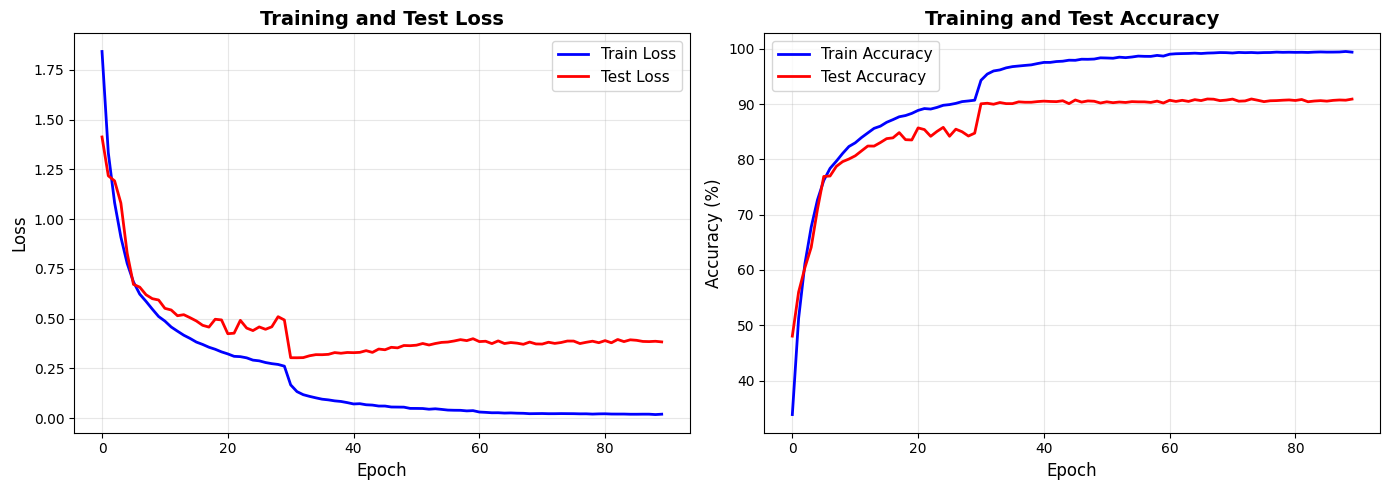


=== Training Summary ===
Best Train Accuracy: 99.51% (Epoch 88)
Best Test Accuracy: 90.92% (Epoch 66)
Final Train Accuracy: 99.39%
Final Test Accuracy: 90.90%


In [13]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(len(history['train_loss']))

# Loss plot
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs, history['test_loss'], 'r-', label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Test Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(epochs, history['test_acc'], 'r-', label='Test Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(args.outdir, 'training_curves.png'), dpi=150, bbox_inches='tight')
print(f"✓ Training curves saved to {args.outdir}/training_curves.png")
plt.show()

# Print summary statistics
print(f"\n=== Training Summary ===")
print(f"Best Train Accuracy: {max(history['train_acc']):.2f}% (Epoch {history['train_acc'].index(max(history['train_acc']))})")
print(f"Best Test Accuracy: {max(history['test_acc']):.2f}% (Epoch {history['test_acc'].index(max(history['test_acc']))})")
print(f"Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final Test Accuracy: {history['test_acc'][-1]:.2f}%")

In [16]:
import os

outdir = '/content/random_smoothing/models/cifar10/resnet18/noise_0.25'
print(f"Contents of {outdir}:")
!ls -lh {outdir}

Contents of /content/random_smoothing/models/cifar10/resnet18/noise_0.25:
total 86M
-rw-r--r-- 1 root root  86M Jan  2 20:55 checkpoint.pth
-rw-r--r-- 1 root root  95K Jan  2 20:55 training_curves.png
-rw-r--r-- 1 root root 3.9K Jan  2 20:55 training_log.txt


In [18]:
from google.colab import files
files.download('/content/random_smoothing/models/cifar10/resnet18/noise_0.25/checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Next Steps

Your CIFAR-10 model with randomized smoothing is now trained!

**What you can do next:**

1. **Download the trained model:**
   ```python
   from google.colab import files
   files.download('/content/models/cifar10/resnet18/noise_0.25/checkpoint.pth')
   ```

2. **Test on individual images:**
   - Load your model and test on custom CIFAR-10 images
   - Visualize certified regions around test samples

3. **Experiment with different noise levels:**
   - Change `args.noise_sd` to 0.0, 0.12, 0.50, or 1.0
   - Compare robustness vs accuracy trade-offs

4. **Try different architectures:**
   - Replace ResNet-18 with ResNet-34, ResNet-50, or other architectures
   - Adjust for different robustness requirements

**Key Results:**
- Model trained on CIFAR-10 (10 classes)
- Randomized smoothing noise σ = 0.25
- Provides provable adversarial robustness guarantees
- Expected accuracy: 70-80% on clean images, 65-75% with noise